Clinical BeRT

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


f:\personalProjects\multimodalHealthAssistant2\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
print("Loading preprocessed data...")

# Load the full processed dataset
df = pd.read_csv('processed_data_v2/full_processed_df.csv')

print(f"Dataset loaded successfully:")
print(f"  - Total samples: {len(df)}")
print(f"  - Columns: {list(df.columns)}")
print(f"  - Text descriptions available: {df['text_description'].notna().sum()}")

# Display sample text descriptions
print(f"Sample text descriptions:")
for i in range(5):
    print(f"{i+1}. {df['text_description'].iloc[i]}")

# Check diagnostic distribution
print(f"Diagnostic distribution:")
print(df['diagnostic'].value_counts())


Loading preprocessed data...
Dataset loaded successfully:
  - Total samples: 1575
  - Columns: ['patient_id', 'lesion_id', 'smoke', 'drink', 'background_father', 'background_mother', 'age', 'pesticide', 'gender', 'skin_cancer_history', 'cancer_history', 'has_piped_water', 'has_sewage_system', 'fitspatrick', 'region', 'diameter_1', 'diameter_2', 'diagnostic', 'itch', 'grew', 'hurt', 'changed', 'bleed', 'elevation', 'img_id', 'biopsed', 'age_group', 'lesion_area', 'lesion_size', 'symptom_score', 'risk_score', 'text_description']
  - Text descriptions available: 1575
Sample text descriptions:
1. 55-year-old female lesion on neck risk factors: skin cancer history, cancer history
2. 77-year-old lesion on face
3. 75-year-old lesion on hand
4. 79-year-old male lesion on forearm risk factors: drink, skin cancer history
5. 52-year-old female lesion on face risk factors: drink, cancer history
Diagnostic distribution:
diagnostic
BCC    845
ACK    730
Name: count, dtype: int64


Text description statistics:
Mean length: 57.2 characters
Median length: 62.0 characters
Min length: 25 characters
Max length: 109 characters


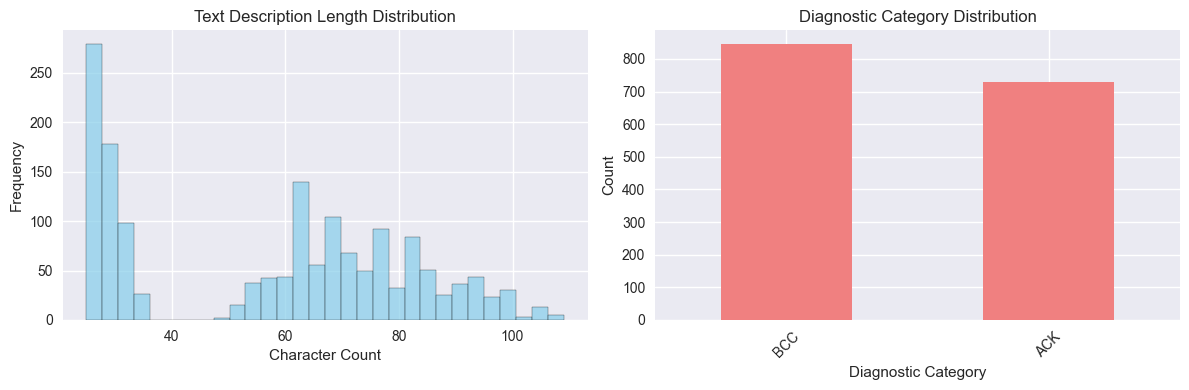


Missing text descriptions: 0


In [4]:
# Text Preprocessing and Analysis
# Analyze text description characteristics
text_lengths = df['text_description'].str.len()
print(f"Text description statistics:")
print(f"Mean length: {text_lengths.mean():.1f} characters")
print(f"Median length: {text_lengths.median():.1f} characters")
print(f"Min length: {text_lengths.min()} characters")
print(f"Max length: {text_lengths.max()} characters")

# Visualize text length distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(text_lengths, bins=30, color='skyblue', alpha=0.7, edgecolor='black')
plt.title('Text Description Length Distribution')
plt.xlabel('Character Count')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
df['diagnostic'].value_counts().plot(kind='bar', color='lightcoral')
plt.title('Diagnostic Category Distribution')
plt.xlabel('Diagnostic Category')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Check for missing text descriptions
missing_text = df['text_description'].isna().sum()
print(f"\nMissing text descriptions: {missing_text}")

# Fill missing descriptions with a default
if missing_text > 0:
    df['text_description'] = df['text_description'].fillna('No description available')
    print("Missing descriptions filled with default text")


In [5]:
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np

model_name = "emilyalsentzer/Bio_ClinicalBERT"

try:
    # Load tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)

    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

    # Set model to evaluation mode
    model.eval()
    model.to("cuda" if torch.cuda.is_available() else "cpu")

    def get_bioclincalbert_embeddings(texts, batch_size=16, max_len=128):
        device = "cuda" if torch.cuda.is_available() else "cpu"
        embeddings = []

        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i+batch_size]

            # Tokenize
            inputs = tokenizer(
                batch_texts,
                padding=True,
                truncation=True,
                max_length=max_len,
                return_tensors="pt"
            ).to(device)

            # Forward pass
            with torch.no_grad():
                outputs = model(**inputs)
                # outputs.last_hidden_state shape: [batch_size, seq_len, hidden_dim]
                batch_embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
                embeddings.append(batch_embeddings)

            if (i // batch_size + 1) % 10 == 0:
                print(f"Processed {i + len(batch_texts)}/{len(texts)} texts...")

        return np.vstack(embeddings)

    print("Generating BioClinicalBERT embeddings...")
    text_list = df['text_description'].astype(str).tolist()
    bioclinicalbert_embeddings = get_bioclincalbert_embeddings(text_list)

    print(f"BioClinicalBERT embeddings shape: {bioclinicalbert_embeddings.shape}")
    print("BioClinicalBERT embeddings created successfully!")

except Exception as e:
    print(f"Error loading BioClinicalBERT model: {e}")
    print("Falling back to TF-IDF approach only...")
    bioclinicalbert_embeddings = None


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


Model parameters: 108,310,272


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


Generating BioClinicalBERT embeddings...
Processed 160/1575 texts...
Processed 320/1575 texts...
Processed 480/1575 texts...
Processed 640/1575 texts...
Processed 800/1575 texts...
Processed 960/1575 texts...
Processed 1120/1575 texts...
Processed 1280/1575 texts...
Processed 1440/1575 texts...
BioClinicalBERT embeddings shape: (1575, 768)
BioClinicalBERT embeddings created successfully!


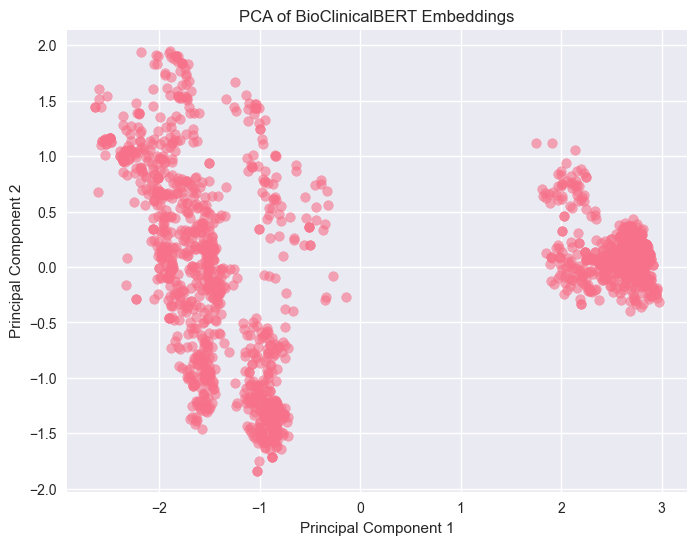

In [6]:
import matplotlib.pyplot as plt
# PCA for BioClinicalBERT embeddings
pca_bioclinicalbert = PCA(n_components=2)
bioclinicalbert_pca = pca_bioclinicalbert.fit_transform(bioclinicalbert_embeddings)
plt.figure(figsize=(8, 6))
plt.scatter(bioclinicalbert_pca[:, 0], bioclinicalbert_pca[:, 1], alpha=0.6)
plt.title('PCA of BioClinicalBERT Embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show() 


In [7]:
import os
import numpy as np

# Ensure embeddings directory exists
os.makedirs('embeddings', exist_ok=True)

# Save BioClinicalBERT embeddings
np.save('embeddings/BioClinical_embeddings.npy', bioclinicalbert_embeddings)
print(f"BioClinical embeddings saved at: embeddings/BioClinical_embeddings.npy")



BioClinical embeddings saved at: embeddings/BioClinical_embeddings.npy
